<a href="https://colab.research.google.com/github/DiegoLeonG96/Tarea4_MLA_UDD/blob/main/Tarea4_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4 Machine Learning Avanzado

Integrantes:
- Kurt Castro
- Diego León

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import math

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

from sklearn.model_selection import train_test_split

## Introducción

## Metodología

## Carga y preparación de datos

define el device para usar gpu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

se cargan las frases inglés y español

In [ ]:
file_path = 'spa.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

source_texts = []
target_texts = []
for line in lines:
    parts = line.strip().split('\t')

    source_texts.append(parts[0])  # Inglés
    target_texts.append(parts[1])  # Español
len(target_texts)

141543

se tokenizan las frases en inglés y español

Se fijan cuáles son los tokens especiales:

- unk: corresponde al token asignado para "desconocido"
- pad: token de padding. Alarga cada secuencia rellenando con este token hasta alcanzar el largo de la secuencia más larga presente en el dataset
- bos: token "beginning of sentence" corresponde al token de inicio de la secuencia
- eos: token "end of sentence" corresponde al token de fin de la secuencia


In [ ]:
# Crear el tokenizador WordLevel
source_tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
source_tokenizer.pre_tokenizer = Whitespace()
target_tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
target_tokenizer.pre_tokenizer = Whitespace()

# Entrenar el tokenizador
source_trainer = WordLevelTrainer(special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"])
source_tokenizer.train_from_iterator(source_texts, trainer=source_trainer)

target_trainer = WordLevelTrainer(special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"])
target_tokenizer.train_from_iterator(target_texts, trainer=target_trainer)

Se obtienen los vocabularios de inglés (source) y español (target). Corresponde a un diccionario donde cada key es un token y cada value es el id asignado

In [ ]:
source_vocab = source_tokenizer.get_vocab()
target_vocab = target_tokenizer.get_vocab()
reversed_tgt_vocab = {v: k for k, v in target_vocab.items()}
reversed_src_vocab = {v: k for k, v in source_vocab.items()}

In [ ]:
print(len(source_vocab))
print(len(target_vocab))

15838
30000


In [ ]:
source_sequences = [source_tokenizer.encode(text).ids for text in source_texts]
target_sequences = [target_tokenizer.encode(text).ids for text in target_texts]

Se agregan explícitamente los tokens especiales definidos anteriormente. Cada secuencia debe comenzar con 2 (bos) y terminar con 3 (eos)

In [ ]:
def add_special_tokens(sequence, bos_id, eos_id):
    """
    Agrega <bos> (inicio de secuencia) y <eos> (fin de secuencia) a una lista de índices.
    """
    return [bos_id] + sequence + [eos_id]

# IDs de los tokens especiales
bos_id_src = source_tokenizer.token_to_id("<bos>")
eos_id_src = source_tokenizer.token_to_id("<eos>")
bos_id_tgt = target_tokenizer.token_to_id("<bos>")
eos_id_tgt = target_tokenizer.token_to_id("<eos>")

# Aplicar tokens especiales a las secuencias
source_sequences = [add_special_tokens(source_tokenizer.encode(text).ids, bos_id_src, eos_id_src) for text in source_texts]
target_sequences = [add_special_tokens(target_tokenizer.encode(text).ids, bos_id_tgt, eos_id_tgt) for text in target_texts]

# Validar
print("Secuencia fuente con tokens especiales (primer ejemplo):", source_sequences[:1])
print("Secuencia destino con tokens especiales (primer ejemplo):", target_sequences[:1])

Secuencia fuente con tokens especiales (primer ejemplo): [[2, 622, 4, 3]]
Secuencia destino con tokens especiales (primer ejemplo): [[2, 1354, 4, 3]]


Guardar un 20% de las secuencias para validación

In [ ]:
src_train_sequences, src_val_sequences, tgt_train_sequences, tgt_val_sequences = train_test_split(
    source_sequences, target_sequences, test_size=0.2, random_state=42)

Definir datasets y dataloaders. Los dataloaders de training y validación corresponden a los iterables que espera el entrenamiento en Pytorch para recorrer el dataset por batches

Se agrega una función collate_fn que se encarga de rellenar con el token de padding

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, source_sequences, target_sequences):
        self.source_sequences = source_sequences
        self.target_sequences = target_sequences

    def __len__(self):
        return len(self.source_sequences)

    def __getitem__(self, idx):
        return self.source_sequences[idx], self.target_sequences[idx]

# Definir función de collate para manejar padding
def collate_fn(batch):
    source_batch, target_batch = zip(*batch)
    source_batch = pad_sequence(source_batch, batch_first=True, padding_value=1)
    target_batch = pad_sequence(target_batch, batch_first=True, padding_value=1)
    return source_batch, target_batch

# Convertir los datos en tensores
src_train_tensors = [torch.tensor(seq, dtype=torch.long) for seq in src_train_sequences]
src_val_tensors = [torch.tensor(seq, dtype=torch.long) for seq in src_val_sequences]
tgt_train_tensors = [torch.tensor(seq, dtype=torch.long) for seq in tgt_train_sequences]
tgt_val_tensors = [torch.tensor(seq, dtype=torch.long) for seq in tgt_val_sequences]

# Crear el dataset
train_dataset = TranslationDataset(src_train_tensors, tgt_train_tensors)
val_dataset = TranslationDataset(src_val_tensors, tgt_val_tensors)

# Crear el DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch))

## Entrenamiento y evaluación de modelos de traducción

### Modelo con atención simple 1

Se define un primer modelo Seq2SeqWithAttention, el cual tiene un mecanismo "suave" de atención, donde se asignan los pesos, puntajes y el vector de contexto

El modelo cuenta con estructura Encoder-Decoder con capas LSTM, además de un embedding el cuál codifica las secuencias de entrada en una representación intermedia

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)

    def forward(self, x):
        return self.embedding(x)

class Encoder(nn.Module):
    def __init__(self, embedding_dim, lstm_units):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, lstm_units, bidirectional=True, batch_first=True)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        hidden = torch.cat((hidden[0], hidden[1]), dim=1).unsqueeze(0)
        cell = torch.cat((cell[0], cell[1]), dim=1).unsqueeze(0)
        return output, hidden, cell

class Decoder(nn.Module):
    def __init__(self, embedding_dim, lstm_units):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, lstm_units * 2, batch_first=True)

    def forward(self, x, hidden, cell):
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        return output, hidden, cell

class Attention(nn.Module):
    def __init__(self, lstm_units):
        super(Attention, self).__init__()
        self.attn = nn.Linear(lstm_units * 4, lstm_units * 2)
        self.v = nn.Linear(lstm_units * 2, 1, bias=False)

    def forward(self, decoder_output, encoder_outputs):

        seq_len_tgt = decoder_output.size(1)
        seq_len_src = encoder_outputs.size(1)

        decoder_expanded = decoder_output.unsqueeze(2).repeat(1, 1, seq_len_src, 1)
        encoder_expanded = encoder_outputs.unsqueeze(1).repeat(1, seq_len_tgt, 1, 1)

        combined = torch.cat((decoder_expanded, encoder_expanded), dim=-1)

        scores = self.v(torch.tanh(self.attn(combined))).squeeze(-1)
        attention_weights = torch.softmax(scores, dim=-1)

        context_vector = torch.bmm(attention_weights, encoder_outputs)
        return context_vector

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Seq2SeqWithAttention, self).__init__()
        self.embedding = EmbeddingLayer(vocab_size, embedding_dim)
        self.encoder = Encoder(embedding_dim, lstm_units)
        self.decoder = Decoder(embedding_dim, lstm_units)
        self.attention = Attention(lstm_units)
        self.fc = nn.Linear(lstm_units * 4, vocab_size)

    def forward(self, encoder_input, decoder_input):
        encoder_embedded = self.embedding(encoder_input)
        decoder_embedded = self.embedding(decoder_input)

        encoder_outputs, hidden, cell = self.encoder(encoder_embedded)
        decoder_outputs, _, _ = self.decoder(decoder_embedded, hidden, cell)

        context_vector = self.attention(decoder_outputs, encoder_outputs)

        combined = torch.cat((decoder_outputs, context_vector), dim=-1)
        output = self.fc(combined)
        return output

definición de hiperparámetros

In [ ]:
# hiperparametros
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
vocab_size = tgt_vocab_size
embedding_dim = 64
lstm_units = 128

simple_model = Seq2SeqWithAttention(vocab_size, embedding_dim, lstm_units).to(device)

Entrenamiento del modelo

Epoch 1/5, Train Loss: 3.4603, Validation Loss: 2.2715
Epoch 2/5, Train Loss: 1.7724, Validation Loss: 1.8363
Epoch 3/5, Train Loss: 1.2558, Validation Loss: 1.7070
Epoch 4/5, Train Loss: 0.9699, Validation Loss: 1.6709
Epoch 5/5, Train Loss: 0.7995, Validation Loss: 1.6697


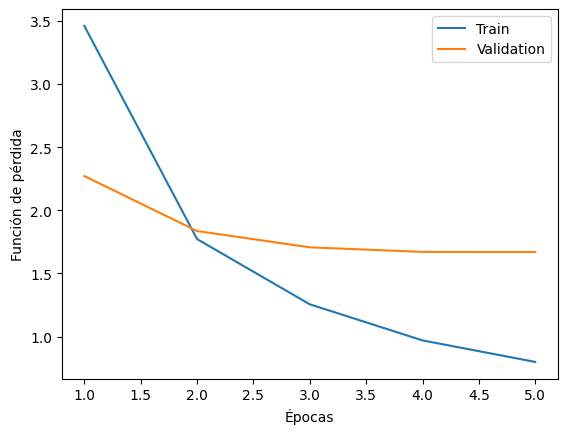

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=1)  # Ignorar el token <pad>
optimizer = torch.optim.Adam(simple_model.parameters(), lr=1e-3)

epochs = 5

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0

    # Modo entrenamiento
    simple_model.train()
    for data in train_dataloader:
        src_data, tgt_data = data
        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)

        # Máscaras de padding
        src_key_padding_mask = (src_data == 1)
        tgt_key_padding_mask = (tgt_data[:, :-1] == 1)

        optimizer.zero_grad()
        output = simple_model(
            src_data,
            tgt_data[:, :-1],
        )

        loss = criterion(output.contiguous().view(-1, vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item() / len(train_dataloader)

    # Modo evaluación
    simple_model.eval()
    with torch.no_grad():
        for data in val_dataloader:
            src_data, tgt_data = data
            src_data = src_data.to(device)
            tgt_data = tgt_data.to(device)

            # Máscaras de padding
            src_key_padding_mask = (src_data == 1)
            tgt_key_padding_mask = (tgt_data[:, :-1] == 1)

            output = simple_model(
                src_data,
                tgt_data[:, :-1],
            )

            loss = criterion(output.contiguous().view(-1, vocab_size), tgt_data[:, 1:].contiguous().view(-1))
            val_epoch_loss += loss.item() / len(val_dataloader)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label='Train')
plt.plot(range(1, epochs + 1), val_losses, label='Validation')
plt.xlabel("Épocas")
plt.ylabel("Función de pérdida")
plt.legend()
plt.show()


Se define la función de traducción para este modelo, la cual toma una secuencia cualquiera de entrada y va generando token por token en el idioma de salida. En cada iteración el modelo genera "el siguiente token más probable".

IMPORTANTE: parte de la lógica de esta función es inspirada en la implementación disponible en https://github.com/shubhamprasad0/transformer-from-scratch/tree/main. Sin embargo, se le realizaron ajustes significativos para poder adaptarlo a este contexto.

In [ ]:
def translate(src, max_seq_len=50):

    tgt_tokens = [""]
    src_tokens = source_tokenizer.encode(src).ids
    src_tokens = add_special_tokens(src_tokens, bos_id_src, eos_id_src)
    src_vectors = torch.tensor([src_tokens], device=device)

    src_key_padding_mask = (src_vectors == 1)  # Padding es 1

    for i in range(max_seq_len): #generar token por token

        temp_chain = " ".join(tgt_tokens).strip()
        tgt_tokens_encoded = target_tokenizer.encode(temp_chain).ids
        tgt_tokens_encoded = add_special_tokens(tgt_tokens_encoded, bos_id_tgt, eos_id_tgt)
        tgt_vectors = torch.tensor([tgt_tokens_encoded], device=device)

        tgt_key_padding_mask = (tgt_vectors == 1)

        output = simple_model(
            src_vectors,
            tgt_vectors[:, :-1],
        )

        idx = torch.argmax(nn.functional.softmax(output, dim=-1)[0, i]).item()

        if idx == target_tokenizer.token_to_id("<eos>"):
            break
        else:
            tgt_tokens.append(reversed_tgt_vocab.get(idx, "<unk>"))

    return " ".join(tgt_tokens[1:]).strip()


Traducciones

In [ ]:
print(translate("English is a extremely complex language, don't you think?"))
print(translate("the day is warm and sunny"))
print(translate("Hello, nice to meet you."))
print(translate("The cat is cute and lazy"))
print(translate("How are you?"))
print(translate("Did you sleep well?"))
print(translate("Attention is all you need"))
print(translate("With Transformers we can solve everything"))
print(translate("There is no future without the now, and right now we are learning about the future"))
print(translate("That's one small step for a man, one giant leap for mankind"))

El inglés es un idioma de extremadamente que lengua no ".
El día está cálido y más .
Hola , te gusto verte .
El gato es mona y se puso
¿ Cómo estás ?
¿ Te has dormido bien ?
Mi mochila es todo lo que te da
Con las tareas podemos resolver a las elecciones .
No hay futuro sin futuro ahora y justo ahora mismo del mundo .
Ese es un hombre más inteligente , uno a las siete de la mañana .


### Modelo transformer

Se define un modelo transformer, el cual contiene un mecanismo de Multi-head attention. Pytorch contiene un módulo en torch.nn.Transformer que encapsula toda la complejidad Encoder-Decoder + Multi-head Attention. Se añaden los embedding de ambos idiomas source y target, los cuales codifican las secuencias entrada a representaciones intermedia en dimensión d_model

In [ ]:
class CustomTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(CustomTransformer, self).__init__()
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.d_model = d_model

        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx = 1)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx = 1)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.transformer = nn.Transform
        er(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 1).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 1).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(src.device)
        tgt_mask = nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, tgt_mask=None):
        # Embedding + Positional Encoding
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        output = self.transformer(
            src_embedded,
            tgt_embedded,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask,
            tgt_mask=tgt_mask
        )
        return self.fc(output)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, d_model, 2).float() * (math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


Definición de hiperparámetros

In [ ]:
# Hiperparámetros
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
embed_dim = 32
num_heads = 4
num_layers = 6
ff_dim = 128
max_seq_length = 100
dropout = 0.1

# Crear el modelo
model = CustomTransformer(
src_vocab_size, tgt_vocab_size, embed_dim, num_heads, num_layers, ff_dim, max_seq_length, dropout
).to(device)


Entrenamiento del modelo

Epoch 1/30, Train Loss: 5.0458, Validation Loss: 4.2695
Epoch 2/30, Train Loss: 4.0661, Validation Loss: 3.7203
Epoch 3/30, Train Loss: 3.6061, Validation Loss: 3.3256
Epoch 4/30, Train Loss: 3.2371, Validation Loss: 2.9888
Epoch 5/30, Train Loss: 2.9316, Validation Loss: 2.7231
Epoch 6/30, Train Loss: 2.6843, Validation Loss: 2.5362
Epoch 7/30, Train Loss: 2.4867, Validation Loss: 2.3915
Epoch 8/30, Train Loss: 2.3335, Validation Loss: 2.2997
Epoch 9/30, Train Loss: 2.2053, Validation Loss: 2.2239
Epoch 10/30, Train Loss: 2.1001, Validation Loss: 2.1573
Epoch 11/30, Train Loss: 2.0110, Validation Loss: 2.1101
Epoch 12/30, Train Loss: 1.9330, Validation Loss: 2.0714
Epoch 13/30, Train Loss: 1.8657, Validation Loss: 2.0312
Epoch 14/30, Train Loss: 1.8073, Validation Loss: 2.0103
Epoch 15/30, Train Loss: 1.7544, Validation Loss: 1.9983
Epoch 16/30, Train Loss: 1.7081, Validation Loss: 1.9696
Epoch 17/30, Train Loss: 1.6653, Validation Loss: 1.9502
Epoch 18/30, Train Loss: 1.6292, Validat

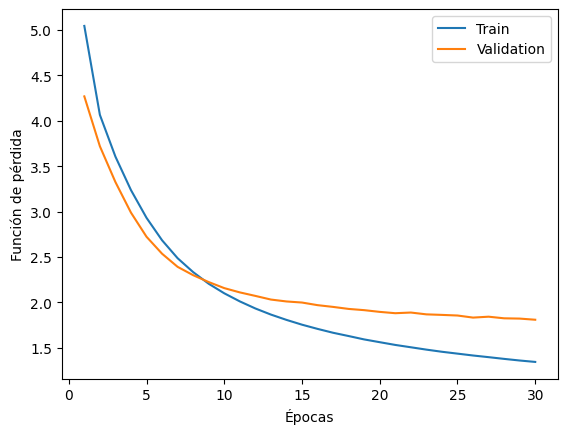

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=1)  # Ignorar <pad>
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 30

train_losses = []
val_losses = []
for epoch in range(epochs):

    train_epoch_loss = 0
    val_epoch_loss = 0

    model.train()
    for data in train_dataloader:
        src_data, tgt_data = data
        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)

        # Máscaras de padding
        src_key_padding_mask = (src_data == 1)
        tgt_key_padding_mask = (tgt_data[:, :-1] == 1)

        # Máscara causal (seq_length, seq_length)
        seq_length = tgt_data[:, :-1].size(1)
        tgt_mask = torch.triu(torch.ones(seq_length, seq_length, device=device), diagonal=1).bool()

        optimizer.zero_grad()
        output = model(
            src_data,
            tgt_data[:, :-1],
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_mask=tgt_mask
        )

        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()/len(train_dataloader)


    model.eval()
    with torch.no_grad():
      for data in val_dataloader:
          src_data, tgt_data = data
          src_data = src_data.to(device)
          tgt_data = tgt_data.to(device)

          # Máscaras de padding
          src_key_padding_mask = (src_data == 1)
          tgt_key_padding_mask = (tgt_data[:, :-1] == 1)

          # Máscara causal (seq_length, seq_length)
          seq_length = tgt_data[:, :-1].size(1)
          tgt_mask = torch.triu(torch.ones(seq_length, seq_length, device=device), diagonal=1).bool()

          output = model(
              src_data,
              tgt_data[:, :-1],
              src_key_padding_mask=src_key_padding_mask,
              tgt_key_padding_mask=tgt_key_padding_mask,
              tgt_mask=tgt_mask
          )

          loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))

          val_epoch_loss += loss.item()/len(val_dataloader)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

plt.figure()
plt.plot(range(1, epochs+1), train_losses, label = 'Train')
plt.plot(range(1, epochs+1), val_losses, label = 'Validation')
plt.xlabel("Épocas")
plt.ylabel("Función de pérdida")
plt.legend()

Se define al igual que los modelos anteriores la función de traducción

In [ ]:
def translate(src, max_seq_len=50):
    tgt_tokens = [""]
    src_vectors = [add_special_tokens(source_tokenizer.encode(src).ids, bos_id_src, eos_id_src)]
    src_vectors = torch.tensor(src_vectors).to(device)

    src_key_padding_mask = (src_vectors == 1)  # Padding es 1

    for i in range(max_seq_len): # generar token por token

        temp_chain = " ".join(tgt_tokens).strip()
        tgt_vectors = [add_special_tokens(target_tokenizer.encode(temp_chain).ids, bos_id_tgt, eos_id_tgt)]
        tgt_vectors = torch.tensor(tgt_vectors).to(device)

        seq_length = tgt_vectors.size(1)
        tgt_mask = torch.triu(torch.ones(seq_length, seq_length, device=device), diagonal=1).bool()

        tgt_key_padding_mask = (tgt_vectors == 1)

        with torch.no_grad():
          output = model(
              src_vectors,
              tgt_vectors,
              src_key_padding_mask=src_key_padding_mask,
              tgt_key_padding_mask=tgt_key_padding_mask,
              tgt_mask=tgt_mask
          )

          # Obtener el índice del token con la mayor probabilidad
          idx = torch.argmax(nn.functional.softmax(output, dim=2)[0, i]).item()

        if idx == target_tokenizer.token_to_id("<eos>"):  # Detener si encuentra fin de cadena
            break
        else:
            tgt_tokens.append(reversed_tgt_vocab.get(idx))

    return " ".join(tgt_tokens[1:]).strip()


Traducciones

In [ ]:
print(translate("English is a extremely complex language, don't you think?"))
print(translate("the day is warm and sunny"))
print(translate("Hello, nice to meet you."))
print(translate("The cat is cute and lazy"))
print(translate("How are you?"))
print(translate("Did you sleep well?"))
print(translate("Attention is all you need"))
print(translate("With Transformers we can solve everything"))
print(translate("There is no future without the now, and right now we are learning about the future"))
print(translate("That's one small step for a man, one giant leap for mankind"))

El inglés es muy compleja , ¿ verdad ?
El día es caluroso y soleado .
Hola , te ves bien .
El gato es lindo y vago .
¿ Cómo son ustedes ?
¿ Has dormido bien ?
Ten cuidado que necesitas .
Asociamos que podemos resolver todo el sonido .
Ahora no hay futuro sin la mejor ahora , ahora estamos en el futuro .
Ese pequeño es una visa para un hombre de la escena .
